# Google Cloud CMIP6 Public Data: Basic Python Example

Edited from: [Pangeo](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html)

This notebooks shows how to query the catalog and load the data using Python

In [133]:
from matplotlib import pyplot as plt, animation
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import zarr
import fsspec

%matplotlib notebook
#%matplotlib widget
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6

## Browse Catalog

The data catatalog is stored as a CSV file. Here we read it with Pandas.

In [134]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


The columns of the dataframe correspond to the CMIP6 controlled vocabulary. A beginners' guide to these terms is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q). 

Here we filter the data to find **monthly surface air temperature** for historical experiments.

In [135]:
df_ta = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical'")

df_ta.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
973,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
1766,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
8074,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
22185,CMIP,IPSL,IPSL-CM6A-LR,historical,r8i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
22298,CMIP,IPSL,IPSL-CM6A-LR,historical,r2i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803


Now we do further filtering to find just the models from NCAR.

In [136]:
df_ta_ncar = df_ta.query('institution_id == "NCAR"')

df_ta_ncar.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
56049,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
56143,CMIP,NCAR,CESM2-WACCM,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
56326,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
59875,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61655,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308


## Load Data

Now we will load a single store using fsspec, zarr, and xarray.

In [137]:
# Get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_ncar.zstore.values[-1]

# Create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# Open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (lat: 96, nbnd: 2, lon: 144, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, nbnd) float64 ...
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, nbnd) float64 ...
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object ...
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           10950.0
    ...                              ...
    tracking_id:                     hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    variable_id:                     tas
    variant_info:                    CMIP6 CESM2-FV2 historical experiment (1...
    variant_label:                   r2i1p1f1
    netcdf_tracking_ids:             hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    version_id:                      v20200226

### Store surface air temperature

In [138]:
ds.tas.to_netcdf("surface_temp.nc")
# Store as numpy files
# latitude = ds.tas.lat
# longitude = ds.tas.lon
# time = ds.tas.time
# np.save("surface_temp.npy", ds.tas.as_numpy() # (time,lat, lon))
# np.save("time.npy", time.as_numpy())
# ...

### Load data

In [139]:
from matplotlib import pyplot as plt, animation
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
tas = xr.open_dataset("surface_temp.nc")

### Plot sample year

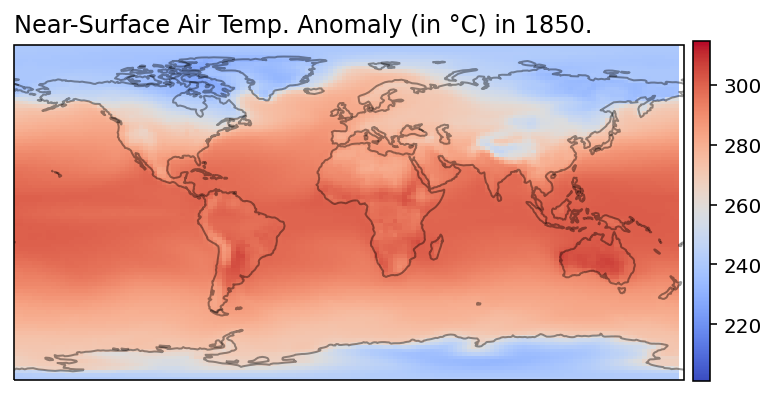

In [140]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
tas.coords['lon'] = (tas.coords['lon'] + 180) % 360 - 180
tas = tas.sortby(tas.lon)

def get_title_tas(idx,data):
    """ Returns the title for the surface temp. plot at idx
    """
    title = f"Near-Surface Air Temp. Anomaly (in °C) in "\
             f"{data.time[idx].dt.year.values}."
     #f"{months[time[idx].dt.month.values-1]}. "\
     #f"{months[data.time[idx].dt.month.values-1]}.",
    return title 

def init_plt(data, idx=0):
    """ Initializes figures and plots one frame.
    """
    # TODO: find out how img should be plotted, as max(lon)==357.5 and not 360
    img_extent = (np.min(data.lon), np.max(data.lon), np.min(data.lat),np.max(data.lat))

    fig = plt.figure()
    crs = ccrs.PlateCarree()
    ax = plt.subplot(1,1,1,projection=crs)
    im = ax.imshow(data.values[idx], origin='lower', 
                   vmin=np.min(data.values), vmax=np.max(data.values),
                   cmap='coolwarm', 
                   extent=img_extent,
                   transform=crs, animated=True) # Init first frame
    im.set_data(data.values[idx,...])
    
    ax.coastlines(alpha=0.4)
    ax.set_global()

    ax.set_title(label=get_title_tas(idx,data), loc='left')

    # Place colorbar
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    cax = fig.add_axes([0.91, 0.210, 0.02, 0.59])
    fig.colorbar(im, cax=cax, orientation='vertical')
    return fig, ax, im

init_plt(tas['tas'])
plt.show()

# Todo: figure out a way to plot with pcolormesh. Current version of pcolormesh 
# requires clipping tas.tas, which skews the plotted values.
#im = ax.pcolormesh(tas.lon, tas.lat, tas.tas[idx,:-1,:-1], transform=crs)
#im.set_array(tas.tas[idx,1:,1:])


In [107]:
def weighted_temporal_mean(ds, var):
    """
    Calculate annual mean while weighting by days in each month
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

average_weighted_temp = weighted_temporal_mean(tas, 'tas')

Queueing 165 frames in animation.


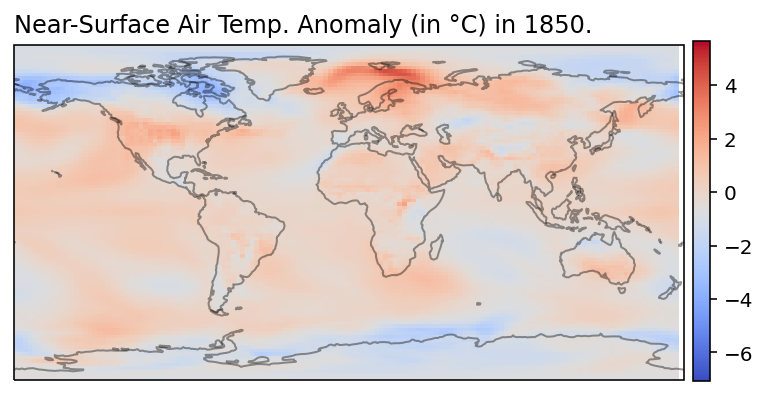

In [141]:
import sys
from tqdm import trange
from tqdm.notebook import tqdm
from IPython.display import display
from IPython.display import HTML

def init_animation(data):
    """ Initializes animation
    """
    global fig, ax, im
    fig, ax, im = init_plt(data)
    im.set_data(np.zeros(data.values[0].shape))
    return

def animate(idx,data):
    """ Adds one frame to the animation 
    """
    ax.set_title(label=get_title_tas(idx,data), loc='left')
    im.set_data(data.values[idx,...])
    #crs = ccrs.PlateCarree()
    #im = ax.pcolormesh(tas.lon, tas.lat, tas.tas[idx,:,:], transform=crs)
    #ax.coastlines(alpha=0.4)
    return im,

def create_animation(data, max_frames=None):
    """
    Creates an animation of a spatiotemporal xarray

    Args
        data xarray: Data over time, lon, lat that should be animated 
    Returns:
        anim matplotlib.animation.FuncAnimation: Animation object
    """
    interval = 1
    # Create animation
    init_animation(data)
    frames = range(data.values.shape[0]) if not max_frames else range(max_frames) # range(40)# tqdm(range(tas.shape[0]), file=sys.stdout)
    print(f'Queueing {len(frames)} frames in animation.')
    anim = animation.FuncAnimation(fig, animate, fargs=(data,),
                                   frames=frames, 
                                   interval=interval, blit=True, repeat=False)
    return anim

# Calculate annual temperature anomaly:
tas_anom = tas # todo: change ot copy 
tas_anom = weighted_temporal_mean(tas_anom, 'tas')
climatology = tas_anom.mean('time')
tas_anom = tas_anom - climatology

anim = create_animation(tas_anom,max_frames=None)

### Render and save animation
This might take a while

In [142]:
%%time
anim.save('animation.mp4', writer=animation.FFMpegWriter(fps=30), dpi=150)

CPU times: user 10.4 s, sys: 2.06 s, total: 12.4 s
Wall time: 13.3 s


In [143]:
from IPython.display import Video
Video("animation.mp4")

# Create a timeseries of global-average surface air temperature. 

For this we need the area weighting factor for each gridpoint.

In [144]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[0]), consolidated=True)
# ds_area

In [145]:
tas = xr.open_dataset("surface_temp.nc")
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# ta_timeseries

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [146]:
%%time
ta_timeseries.load()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.35 ms


<xarray.DataArray (time: 1980)>
array([0.00407822, 0.00405088, 0.0039282 , ..., 0.00411686, 0.00414686,
       0.00418852], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

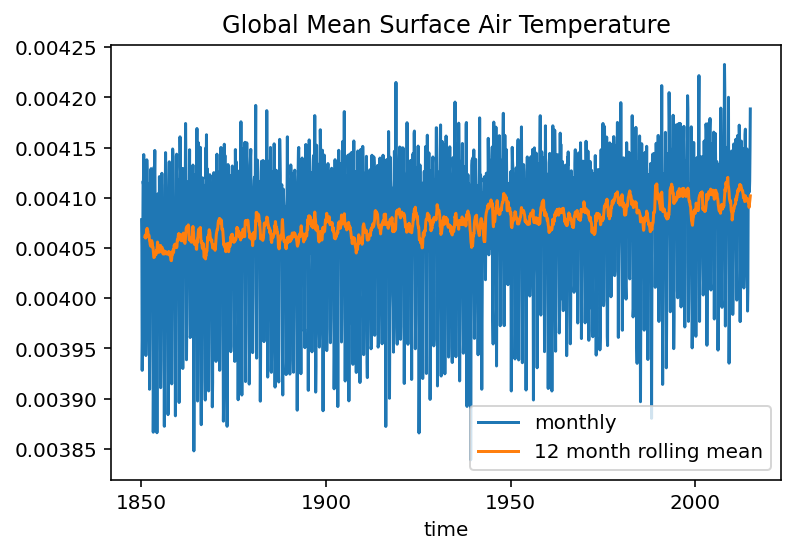

In [147]:
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')